In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import os
from pathlib import Path

In [108]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization #type:ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler #type:ignore
from tensorflow.keras.utils import to_categorical #type:ignore
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.regularizers import l2 #type:ignore
from tensorflow.keras.optimizers import Adam #type:ignore

np.random.seed(42)
tf.random.set_seed(42)

In [109]:
script_folder = Path(os.getcwd())
dataset_folder = script_folder.parent / "data"

print("Code Location: ", script_folder)
print("Dataset Location: ", dataset_folder)

Code Location:  d:\Coding\Jupyter\Weather-AUS\SimpleNN
Dataset Location:  d:\Coding\Jupyter\Weather-AUS\data


In [110]:
df = pd.read_csv(dataset_folder / "weatherAUS.csv")
print(f"Original shape: {df.shape}")
df

Original shape: (145460, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [111]:
print("missing values:\n", df.isnull().sum()[df.isnull().sum() > 0])

missing values:
 MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


In [112]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print(f"numerical columns: {len(numerical_cols)}")
print(f"categorical columns: {len(categorical_cols)}")

numerical columns: 16
categorical columns: 7


In [113]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfYear'] = df['Date'].dt.dayofyear
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [114]:
# Create cyclical features for temporal patterns
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

fill missing values

In [115]:
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    if col != 'RainTomorrow':
        df[col] = df[col].fillna(df[col].mode()[0])

drop date 

In [116]:
df = df.drop('Date', axis=1)

drop remaining null values, then calculate lost rows

In [117]:
before = df.shape[0]
df.dropna(inplace=True)
print(f"Rows lost: {before - df.shape[0]}, ~ {round((before - df.shape[0]) / before * 100, 4)}%")

Rows lost: 3267, ~ 2.246%


encoding

In [118]:
le = LabelEncoder()
for col in ['Location', 'RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))
        
df['RainTomorrow'] = le.fit_transform(df['RainTomorrow'])

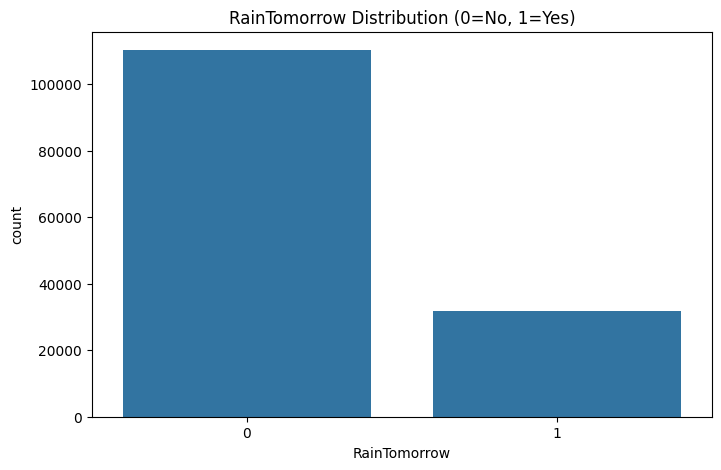

In [119]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df['RainTomorrow'])
plt.title("RainTomorrow Distribution (0=No, 1=Yes)")
plt.show()

features engineering

In [120]:
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

In [121]:
#df['Rainfall_lag1'] = df['Rainfall'].shift(1)

In [122]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

corr = pd.DataFrame(X_train.copy())
corr['RainTomorrow'] = y_train
corr = corr.corr(numeric_only=True)['RainTomorrow'].abs().sort_values(ascending=False)
top_features = corr[corr > 0.05].index.tolist()
top_features.remove('RainTomorrow')
X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]

In [123]:
# class_counts = np.bincount(y_train)
# total = len(y_train)
# class_weight = {0: total / (2 * class_counts[0]), 
#                 1: total / (2 * class_counts[1])}
# print(f"Class weights: {class_weight}")

In [124]:
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)


from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_s, y_train) #type: ignore

Train: (99535, 17), Val: (21329, 17), Test: (21329, 17)


Define NN

Simplified (redundant)

In [125]:
input_dim=X_train_res.shape[1] 
dropout_rate=0.3

model = Sequential()
model.add(Input(shape=(input_dim,)))

model.add(Dense(256, activation='relu', kernel_regularizer= l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Dense(128, activation='relu', kernel_regularizer= l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Dense(64, activation='relu', kernel_regularizer= l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate / 2))

model.add(Dense(32, activation='relu', kernel_regularizer= l2(0.001)))
model.add(Dropout(dropout_rate / 2))

model.add(Dense(1, activation='sigmoid'))

actual more configurable way, also compact

In [126]:
params = {
    "dense_units": [256, 128, 64, 32],
    "dropout": 0.2,
    "lr": 1e-3,
    "batch_norm": True,
}


model = Sequential()
model.add(Input(shape=(X_train_res.shape[1],)))

for i, units in enumerate(params["dense_units"]):
    model.add(Dense(units, activation='relu', kernel_regularizer=l2(0.001)))
    if params["batch_norm"]:
        model.add(BatchNormalization())
    model.add(Dropout(params["dropout"] if i < 2 else params["dropout"]/2))

model.add(Dense(1, activation='sigmoid'))
    
model.compile(
    optimizer=Adam(learning_rate=params["lr"]),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 256)               4608      
                                                                 
 batch_normalization_18 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_19 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_22 (Dropout)        (None, 128)              

model training

In [127]:
def lr_scheduler(epoch, lr):
    return lr * 0.95 if epoch > 5 else lr

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.33, patience=2, min_lr=1e-6),
    ModelCheckpoint(script_folder / "NNmodel.h5", monitor='val_loss', save_best_only=True, verbose=0),
    LearningRateScheduler(lr_scheduler)
]


history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_val_s, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
4827/4827 [==============================] - 86s 18ms/step - loss: 0.5933 - accuracy: 0.7767 - val_loss: 0.4923 - val_accuracy: 0.7639 - lr: 0.0010
Epoch 2/50
4827/4827 [==============================] - 84s 17ms/step - loss: 0.4807 - accuracy: 0.7818 - val_loss: 0.4975 - val_accuracy: 0.7498 - lr: 0.0010
Epoch 3/50
4827/4827 [==============================] - 84s 17ms/step - loss: 0.4760 - accuracy: 0.7822 - val_loss: 0.4652 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 4/50
4827/4827 [==============================] - 79s 16ms/step - loss: 0.4728 - accuracy: 0.7825 - val_loss: 0.4463 - val_accuracy: 0.7790 - lr: 0.0010
Epoch 5/50
4827/4827 [==============================] - 84s 17ms/step - loss: 0.4707 - accuracy: 0.7830 - val_loss: 0.4777 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 6/50
4827/4827 [==============================] - 78s 16ms/step - loss: 0.4689 - accuracy: 0.7841 - val_loss: 0.4654 - val_accuracy: 0.7493 - lr: 3.3000e-04
Epoch 7/50
4827/4827 [====================

evaluation

In [128]:
val_loss, val_acc = model.evaluate(X_val_s, y_val)
test_loss, test_acc = model.evaluate(X_test_s, y_test)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

667/667 [==============================] - 4s 5ms/step - loss: 0.4177 - accuracy: 0.8060
Validation Accuracy: 0.7997
Test Accuracy: 0.8060


667/667 [==============================] - 2s 3ms/step


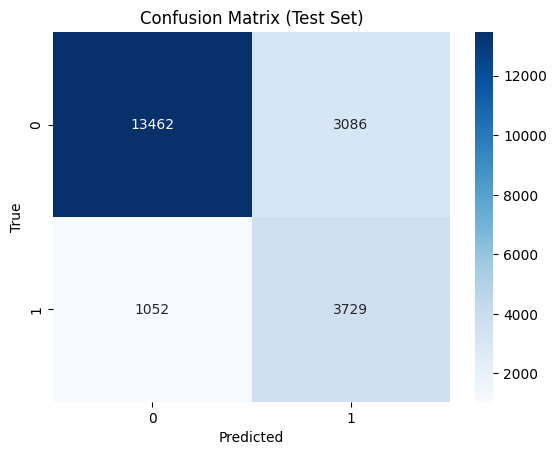

In [129]:
y_pred = (model.predict(X_test_s) > 0.5).astype(int).ravel()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [130]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score :", f1_score(y_test, y_pred, average='weighted'))

Accuracy : 0.8059918420929251
Precision: 0.8422625288764596
Recall   : 0.8059918420929251
F1 Score : 0.816654857629717


In [131]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9275    0.8135    0.8668     16548
           1     0.5472    0.7800    0.6432      4781

    accuracy                         0.8060     21329
   macro avg     0.7373    0.7967    0.7550     21329
weighted avg     0.8423    0.8060    0.8167     21329



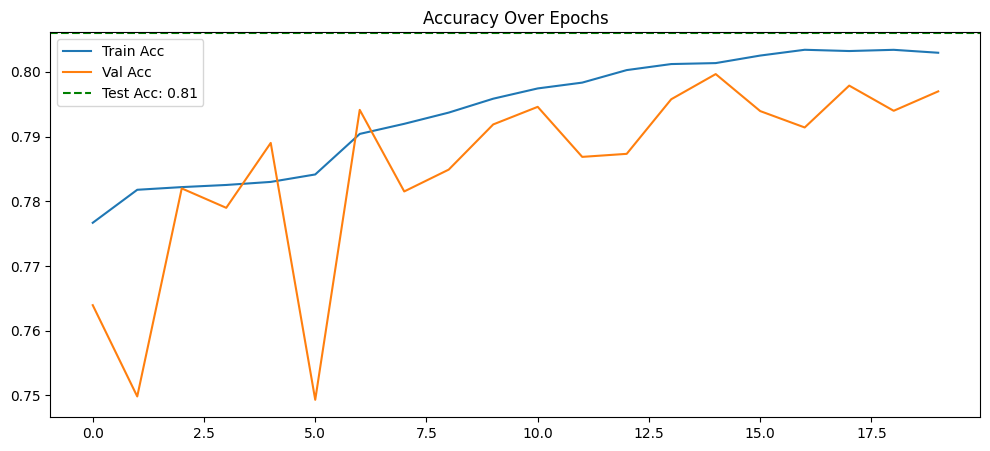

In [132]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.axhline(y=test_acc, color='green', linestyle='--', label=f"Test Acc: {test_acc:.2f}")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()